<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Natural Language Processing</h1>
<h1>Named Entity Recognition</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from IPython.display import display

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm

import string

import nltk
from nltk.corpus import treebank
from nltk.tag import hmm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: dcc62f994628bd6ae202ab542b8409b1167569d6

pandas    : 1.1.3
nltk      : 3.5
numpy     : 1.19.2
matplotlib: 3.3.2
json      : 2.0.9
watermark : 2.1.0
tqdm      : 4.62.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Part-Of-Speech Tagging

Let's consider a simple example

In [4]:
text = "They refuse to permit us to obtain the refuse permit"

The first step is to tokenize the text. Since we'll be feeding this text back to nltk for the pos analysis it's best ot use the default tokenizer as that preserves punctuation characters that provide important clues about the meaning and grammatical role of each word.

In [5]:
tokens = nltk.word_tokenize(text)

And finally passing the tokens to the pos tagger

In [6]:
tags = nltk.pos_tag(tokens)

and, as expected

In [7]:
pprint(tags)

[('They', 'PRP'),
 ('refuse', 'VBP'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]


We can easily obtain the full list of tags for the default tagger

In [8]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

Training a pos_tagger is also straightforward. We'll use the pre-tagged TreeBank corpus as our training dataset.

In [8]:
train_data = treebank.tagged_sents()

For this example, we'll use the Hidden Markov Model Tagger. We start by instanciating the HMM trainer object

In [9]:
trainer = hmm.HiddenMarkovModelTrainer()

And then training it with the upenn training corpus

In [10]:
tagger = trainer.train_supervised(train_data)

so we can now use our trained tokenizer just like we used pos_tag()

In [11]:
pprint(tagger.tag(nltk.word_tokenize(text)))

[('They', 'PRP'),
 ('refuse', 'VBP'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'VBP'),
 ('permit', 'VB')]


You'll note that in this simple example, the HMM tagger mistags the second instances of refuse and permit, highlighting the fact that these algorithms are statistic in nature and you should always check the results to make sure they make sense for your specific application.

If we use an even simpler tagger, the results are even less appealing. Let us defined a set of regular expressions to map tokens to POS categories (based on https://tedboy.github.io/nlps/generated/generated/nltk.RegexpTagger.html)

In [12]:
regexp = [
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'AT'),   # articles
    (r'.*able$', 'JJ'),                # adjectives
    (r'.*ness$', 'NN'),                # nouns formed from adjectives
    (r'.*ly$', 'RB'),                  # adverbs
    (r'.*s$', 'NNS'),                  # plural nouns
    (r'.*ing$', 'VBG'),                # gerunds
    (r'.*ed$', 'VBD'),                 # past tense verbs
    (r'.*', 'NN')                      # nouns (default)
]

Now er create a RegexpTagger based on these definitions

In [13]:
regexp_tagger = nltk.tag.RegexpTagger(regexp)

and use it to tag our text

In [14]:
regexp_tagger.tag(nltk.word_tokenize(text))

[('They', 'NN'),
 ('refuse', 'NN'),
 ('to', 'NN'),
 ('permit', 'NN'),
 ('us', 'NNS'),
 ('to', 'NN'),
 ('obtain', 'NN'),
 ('the', 'AT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]

The results are... less than impressive

# Chunking

Let us go back to our favourite nursery rhyme:

In [15]:
text = """Mary had a little lamb, little lamb,
    little lamb. Mary had a little lamb
    whose fleece was white as snow.
    And everywhere that Mary went
    Mary went, MARY went. Everywhere
    that mary went,
    The lamb was sure to go"""

We're going to extract a single sentence and extract the POS tags for each token

In [16]:
sentences = nltk.sent_tokenize(text)
text = sentences[1]
tokens = nltk.word_tokenize(text)
pos_tags = nltk.pos_tag(tokens)

So far so good

In [17]:
pos_tags

[('Mary', 'NNP'),
 ('had', 'VBD'),
 ('a', 'DT'),
 ('little', 'JJ'),
 ('lamb', 'NN'),
 ('whose', 'WP$'),
 ('fleece', 'NN'),
 ('was', 'VBD'),
 ('white', 'JJ'),
 ('as', 'IN'),
 ('snow', 'NN'),
 ('.', '.')]

Before we can proceed to chunking this sentence, we need to create a grammar defining our how chunks should look like. For simplicity, we'll just define a rule for Noun Phrases to be an optional Determiners followed by 0 or more adjectives and one or more nouns. (from https://www.nltk.org/book/ch07.html#noun-phrase-chunking)

In [18]:
grammar = "NP: {<DT>?<JJ.*>*<NN.*>+}"

We use a RegexpParser as a chunk parser after initializing it with this simple grammar

In [20]:
cp = nltk.RegexpParser(grammar)

and we can now chunk the tags of our sentence

In [21]:
result = cp.parse(pos_tags)

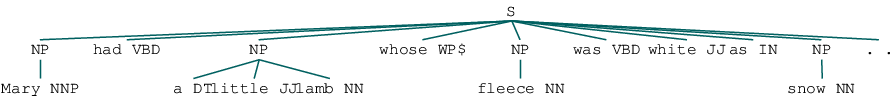

In [22]:
result

As we can see, the algorithm correctly identified "Mary", "a little lamb", "fleece" and "snow" as Noun Phrases that follow our grammars definition

Now all we have to do is traverse the tree looking for nodes labeled 'NP' and print the leaves they contain

In [23]:
for i, subtree in enumerate(result.subtrees(filter=lambda t: t.label() == 'NP')):
    print(i, " ".join([token for token, pos in subtree.leaves()]))

0 Mary
1 a little lamb
2 fleece
3 snow


The procedure is the same, regardless of how complex is the grammar we define

In [24]:
grammar = r"""
  NP: {<DT>?<JJ.*>*<NN.*>+}    # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)

In [25]:
result = cp.parse(pos_tags)

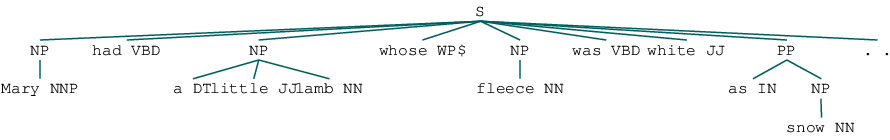

In [26]:
result

But as long as the definition of the Noun Phrases remains the same, so does the result

In [27]:
for i, subtree in enumerate(result.subtrees(filter=lambda t: t.label() == 'NP')):
    print(i, " ".join([token for token, pos in subtree.leaves()]))

0 Mary
1 a little lamb
2 fleece
3 snow


And we can just as easily extract whatever node we are interested in:

In [28]:
for i, subtree in enumerate(result.subtrees(filter=lambda t: t.label() == 'PP')):
    print(i, " ".join([token for token, pos in subtree.leaves()]))

0 as snow


# Chinking

The chunk you remove from your chunk is your chink! This grammar starts by assigning everyhting into a single chunk and them breaking off past tense verbs (VDB) and propositions (IN)

In [29]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<VBD|IN>+{      # Chink sequences of VBD and IN
  """

So our example now looks like

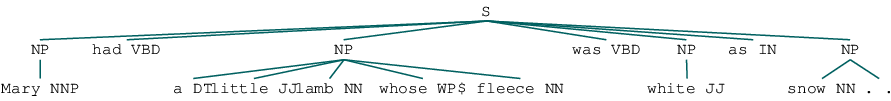

In [30]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tags)

# Named Entity Recognition

In [31]:
sentence = """Two U.S. senators on Wednesday pressed the Federal Trade Commission to probe Tesla"""

We tokenize and add POS tags

In [32]:
tokens = nltk.word_tokenize(sentence)
pos_tags = nltk.pos_tag(tokens)

And define our Chunking grammar

In [33]:
grammar = r"""
  NP: {<DT>?<JJ.*>*<NN.*>+}    # Chunk sequences of DT, JJ, NN
  """
cp = nltk.RegexpParser(grammar)

Perform simple Chunking

In [34]:
chunked_tags = cp.parse(pos_tags)

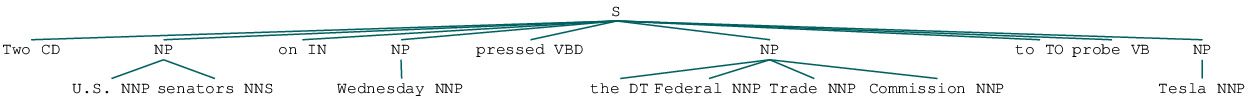

In [35]:
chunked_tags

And, finally, identify the Named Entities

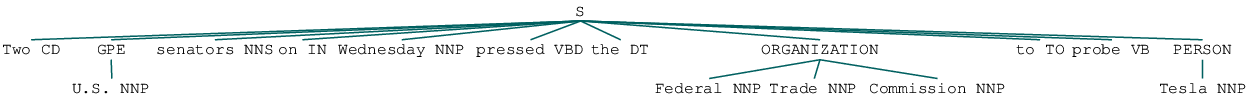

In [36]:
nltk.ne_chunk(pos_tags)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>